# Applying Trained ESP-CNN and DCNN for Super Resolution and Denoising

**Author:** [Pritom Mojumder](https://github.com/ipritom)<br>
**Date created:** 2021/08/22<br>

**Description:** Utilising Pretrained weights for acheiving super resolution and reduced noise on video and image.

Use `weights.zip` for pretrained weights.

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

### Unzip Pretrained Weights
Drag and drop the weights.zip or put the path of the weights.zip file in the cell bellow.

In [ ]:
!unzip weights.zip

Archive:  weights.zip
   creating: weights/
   creating: weights/CNNweights/
   creating: weights/CNNweights/checkpoint/
  inflating: weights/CNNweights/checkpoint/checkpoint  
  inflating: weights/CNNweights/checkpoint/checkpoint.data-00000-of-00001  
  inflating: weights/CNNweights/checkpoint/checkpoint.index  
   creating: weights/ESPCNNweights/
   creating: weights/ESPCNNweights/checkpoint/
  inflating: weights/ESPCNNweights/checkpoint/checkpoint  
  inflating: weights/ESPCNNweights/checkpoint/checkpoint.data-00000-of-00001  
  inflating: weights/ESPCNNweights/checkpoint/checkpoint.index  


# Define utility functions

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def denoise_image(model,img):
    """Return image passed through the given model."""

    y = img_to_array(img)
    y = y.astype("float32") / 255.0
    
    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y = out_img_y*255

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    
    return array_to_img(out_img_y)

In [ ]:
upscale_factor = 3

In [ ]:
def get_model_ESPCNN(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 7, **conv_args)(inputs)
    x = layers.Conv2D(64, 5, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x) #extra layer
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

def get_model_DCNN(upscale_factor=1, channels=3):
    conv_args = {
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 7, **conv_args)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 5, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    outputs = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    # outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Get Models and Load Weights

- ESPCNN is for Super Resulution get by `get_model_ESPCNN` function.

- DCNN is for Denoising Images get by `get_model_DCNN` function.

- Pretrained weights are in weights folder. (unzip weights.zip)

In [ ]:
# get model for super resolution
model = get_model_ESPCNN(upscale_factor=upscale_factor, channels=1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    102464    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0     

In [ ]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=optimizer, loss=loss_fn,
)
model.load_weights('weights/ESPCNNweights/checkpoint/checkpoint')

In [ ]:
# get model for denoising
model_denoiser = get_model_DCNN(upscale_factor=1, channels=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    102464    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0     

In [ ]:
model_denoiser.compile(
    optimizer=optimizer, loss=loss_fn,
)
model_denoiser.load_weights('weights/CNNweights/checkpoint/checkpoint')

# Using Trained Models

## Super Resolution

In [ ]:
#project directory and sample direcotry
project_path = 'drive/MyDrive/Project/'
test_sample_path = 'drive/MyDrive/Project/test_samples/'

In [ ]:
sample1 = test_sample_path +'original1_low_res.jpg'
sample2 = test_sample_path +'original2_low_res.jpg'

In [ ]:
img1 = load_img(sample1)
img2 = load_img(sample2)

In [ ]:
predicted1 = upscale_image(model, img1)
predicted2 = upscale_image(model, img2)

__TEST SAMPLE 1: Input & Output__


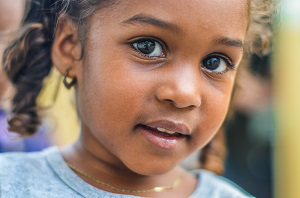

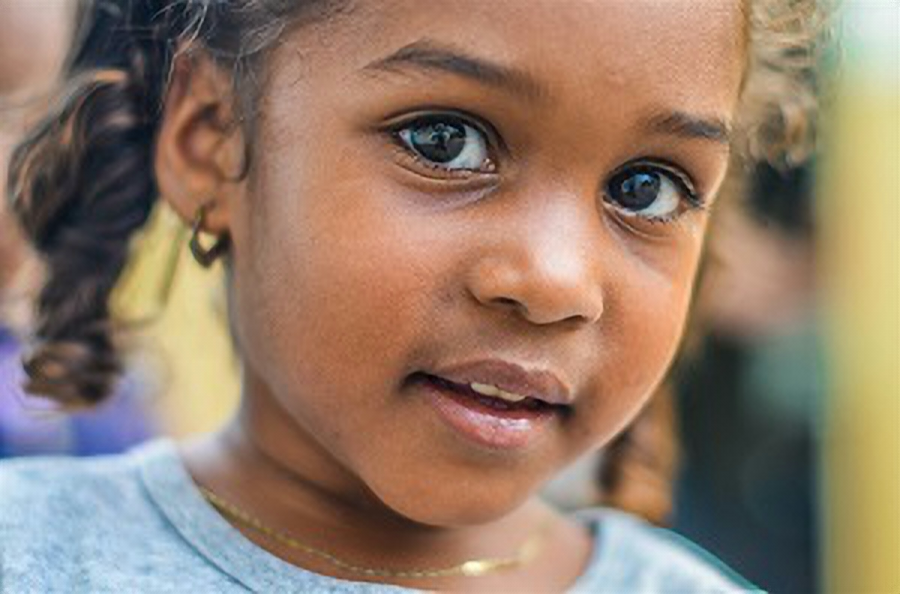

__TEST SAMPLE 2: Input & Output__


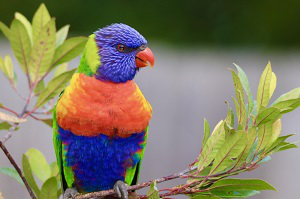

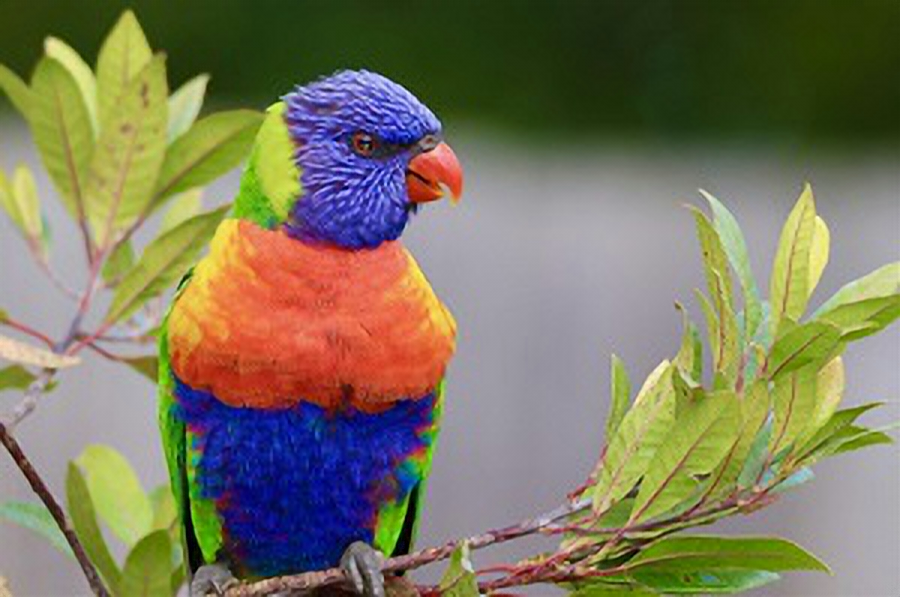

In [ ]:
print("__TEST SAMPLE 1: Input & Output__")
display(img1)
display(predicted1)
print("__TEST SAMPLE 2: Input & Output__")
display(img2)
display(predicted2)

## Denoising

In [ ]:
sample1_noisy = test_sample_path +'original1_noisy.jpg'
sample2_noisy = test_sample_path +'original2_noisy.jpg'

In [ ]:
img1_noisy = load_img(sample1_noisy)
img2_noisy = load_img(sample2_noisy)

In [ ]:
predicted1_denoised = denoise_image(model_denoiser, img1_noisy)
predicted2_denoised = denoise_image(model_denoiser, img2_noisy)


__TEST SAMPLE 1: Input & Output__



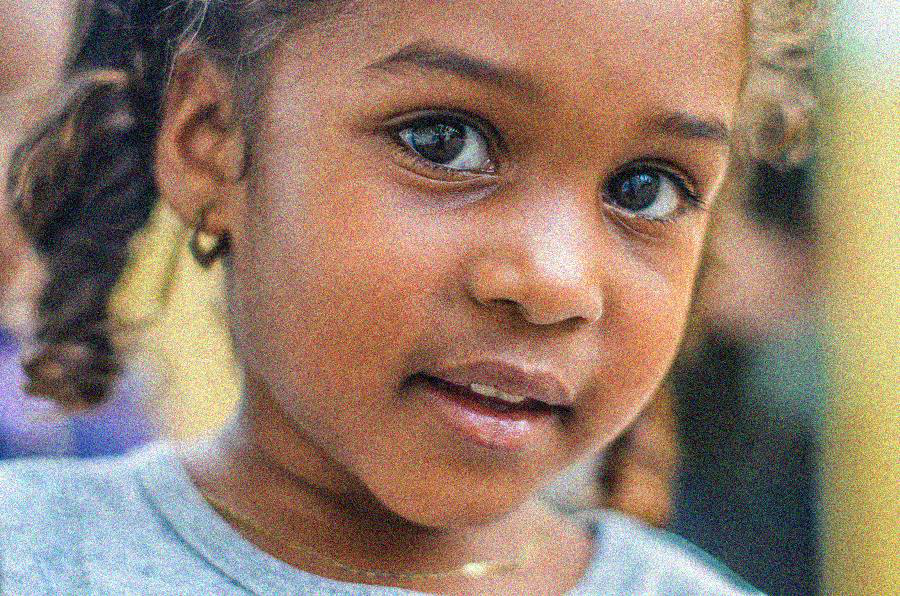

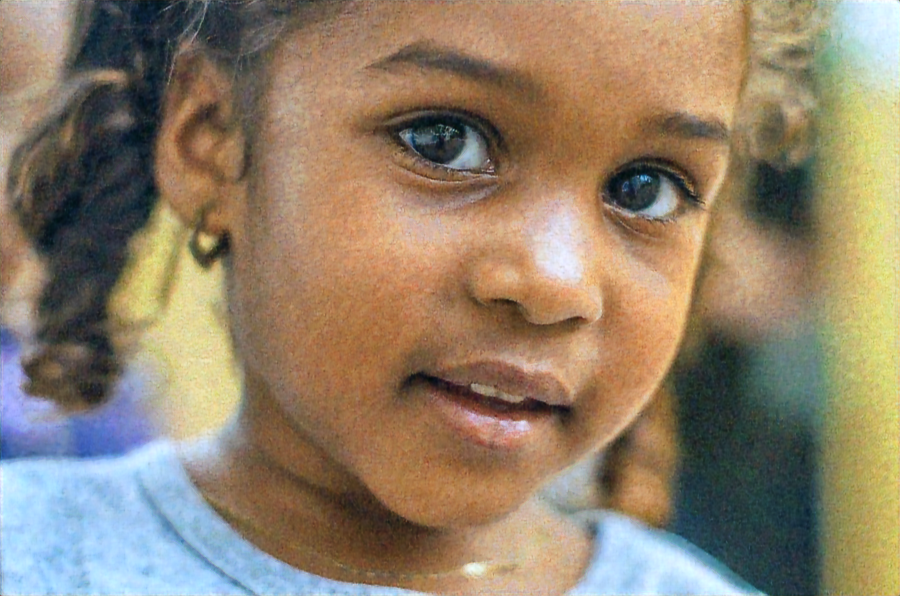


__TEST SAMPLE 1: Input & Output__



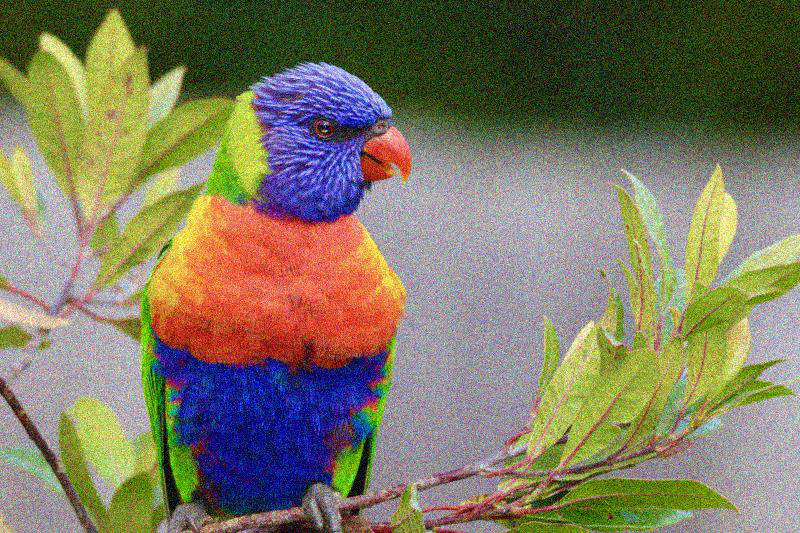

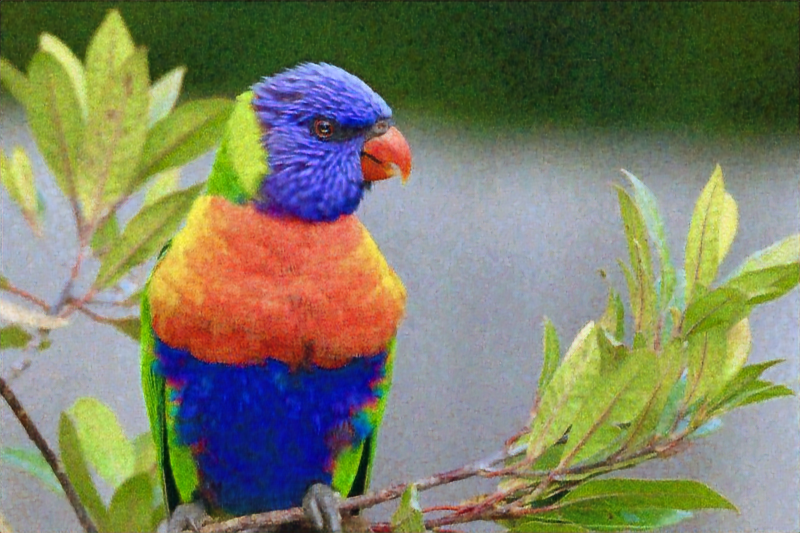

In [ ]:
print("\n__TEST SAMPLE 1: Input & Output__\n")
display(img1_noisy)
display(predicted1_denoised)
print("\n__TEST SAMPLE 1: Input & Output__\n")
display(img2_noisy)
display(predicted2_denoised)

# Super Resolution on Video

We can utisize ESP-CNN on video. Here ESP-CNN will be applied on each frame of a video.

## Loading Video Data

In [ ]:
sample_video_path = project_path + 'mountain480p.mp4'

## Setup moviepy

In [ ]:
!pip install moviepy

In [ ]:
from moviepy.editor import VideoFileClip, ImageClip, concatenate, concatenate_videoclips
from tqdm import tqdm
import gc

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2351104/45929032 bytes (5.1%)5783552/45929032 bytes (12.6%)9297920/45929032 bytes (20.2%)12804096/45929032 bytes (27.9%)16334848/45929032 bytes (35.6%)19832832/45929032 bytes (43.2%)23347200/45929032 bytes (50.8%)26779648/45929032 bytes (58.3%)30203904/45929032 bytes (65.8%)33464320/45929032 bytes (72.9%)36929536/45929032 bytes (80.4%)40394752/45929032 bytes (88.0%)

## Utiity Functions

- `video_upsample` This function takes model and video as input and write video with increased resolution.

**Note** : This process is slow and resource hungry. Video more than 15 sec may require additional memory resource.

In [ ]:
def video_upsample(model,video):
    """Upsample Video Frames and Save it to the directory"""

    clip_frames = []
    clips = []
    fps = video.fps
    # frames = iter_frames(model,video,fps) #generator function for video frames
    n_frames = video.reader.nframes #take number of frames
    nth_clip = 0
    print(f"Start Video Upsampling | Total Frames: {n_frames}")
    #iter over frames
    for i,frame in enumerate(video.iter_frames()):
        prediction = upscale_image(model, array_to_img(frame))
        frame_ = ImageClip(img_to_array(prediction)).set_duration(1/fps)
        clip_frames.append(frame_)

        #saving subclip
        if i!=0 and i%50==0: 
            nth_clip +=1
            subclip_name = 'subclip'+str(nth_clip)+'.mp4'
            subclip = concatenate(clip_frames, method="compose")
            subclip.write_videofile(subclip_name, fps=fps)

            print(f'{i}/{n_frames} Completed')
            clip_frames.clear()
            clips.append(subclip_name)
            gc.collect()

    #saving rest of the frames as a subclip if any
    if clip_frames != []:
        nth_clip +=1
        subclip = concatenate(clip_frames, method="compose")
        subclip_name = 'subclip'+str(nth_clip)+'.mp4'
        subclip.write_videofile(subclip_name, fps=fps)
        print(f'{n_frames}/{n_frames} Completed')
        clip_frames.clear()
        clips.append(subclip_name)
        gc.collect()

    #loading sub clips
    subclips = []
    for clip in clips:
        subclips.append(VideoFileClip(clip))
    
    #merging sub clips and save to directory
    new_video = concatenate_videoclips(subclips, method="compose")
    new_video.write_videofile('test1.mp4', fps=fps)
    
    #removing subclips
    for clip in clips: os.remove(clip)

In [ ]:
myclip = VideoFileClip(sample_video_path)

In [ ]:
video_upsample(model, myclip)

Start Video Upsampling | Total Frames: 452
[MoviePy] >>>> Building video subclip1.mp4
[MoviePy] Writing video subclip1.mp4


100%|██████████| 52/52 [00:04<00:00, 11.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip1.mp4 

50/452 Completed
[MoviePy] >>>> Building video subclip2.mp4
[MoviePy] Writing video subclip2.mp4


100%|██████████| 51/51 [00:04<00:00, 10.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip2.mp4 

100/452 Completed
[MoviePy] >>>> Building video subclip3.mp4
[MoviePy] Writing video subclip3.mp4


100%|██████████| 51/51 [00:04<00:00, 10.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip3.mp4 

150/452 Completed
[MoviePy] >>>> Building video subclip4.mp4
[MoviePy] Writing video subclip4.mp4


100%|██████████| 51/51 [00:04<00:00, 11.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip4.mp4 

200/452 Completed
[MoviePy] >>>> Building video subclip5.mp4
[MoviePy] Writing video subclip5.mp4


100%|██████████| 51/51 [00:04<00:00, 11.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip5.mp4 

250/452 Completed
[MoviePy] >>>> Building video subclip6.mp4
[MoviePy] Writing video subclip6.mp4


100%|██████████| 51/51 [00:04<00:00, 11.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip6.mp4 

300/452 Completed
[MoviePy] >>>> Building video subclip7.mp4
[MoviePy] Writing video subclip7.mp4


100%|██████████| 51/51 [00:04<00:00, 11.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip7.mp4 

350/452 Completed
[MoviePy] >>>> Building video subclip8.mp4
[MoviePy] Writing video subclip8.mp4


100%|██████████| 51/51 [00:04<00:00, 11.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip8.mp4 

400/452 Completed
[MoviePy] >>>> Building video subclip9.mp4
[MoviePy] Writing video subclip9.mp4


100%|██████████| 51/51 [00:04<00:00, 10.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip9.mp4 

450/452 Completed
[MoviePy] >>>> Building video subclip10.mp4
[MoviePy] Writing video subclip10.mp4


 50%|█████     | 1/2 [00:00<00:00, 15.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip10.mp4 



452/452 Completed
[MoviePy] >>>> Building video test1.mp4
[MoviePy] Writing video test1.mp4


100%|██████████| 461/461 [01:54<00:00,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test1.mp4 



### Diagnose Frames in Video 

For some video encodings `moviepy` module may not work. I've faced problem of glithes with frames. To quick check uncomment and run the lines bellow. If frames are perfect then it can be used to upscale.

In [ ]:
# count = 0
# for frame in myclip.iter_frames():
#     count +=1
#     display(array_to_img(frame))
#     if count >3:break